In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats

import statsmodels
from statsmodels.stats.anova import AnovaRM


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
import bootstrap_confidence
bootstrap_confidence.bootstrap_correct_incorrect_checker_sepsides(n_boot_iter=1000)

0
[-0.53 -0.41 -0.29  0.29  0.41  0.53]
23 9
14 9
1 9
3 9
15 9
22 9
5 9
2 9
3 9
1 9
1 9
6 9
[-0.53 -0.41  0.41  0.53]
15 13
5 13
10 13
20 13
13 13
11 13
6 13
8 13
[-0.53 -0.41  0.41  0.53]
15 13
5 13
15 13
22 13
13 13
11 13
1 13
6 13
[-0.53 -0.41 -0.29  0.29  0.41  0.53]
23 9
14 9
1 9
3 9
10 9
20 9
5 9
2 9
3 9
1 9
6 9
8 9
1
[-0.53 -0.41 -0.29 -0.18  0.18  0.29  0.41  0.53]
5 7
5 7
12 7
3 7
3 7
16 7
7 7
4 7
3 7
7 7
8 7
5 7
5 7
4 7
5 7
4 7
[-0.53 -0.41 -0.29 -0.18  0.18  0.29  0.41  0.53]
7 7
11 7
11 7
6 7
5 7
15 7
8 7
6 7
1 7
1 7
9 7
2 7
3 7
5 7
4 7
2 7
[-0.53 -0.41 -0.29 -0.18  0.18  0.29  0.41  0.53]
7 7
11 7
11 7
6 7
3 7
16 7
7 7
4 7
1 7
1 7
9 7
2 7
5 7
4 7
5 7
4 7
[-0.53 -0.41 -0.29 -0.18  0.18  0.29  0.41  0.53]
5 7
5 7
12 7
3 7
5 7
15 7
8 7
6 7
3 7
7 7
8 7
5 7
3 7
5 7
4 7
2 7
2
[-0.64 -0.53 -0.29  0.29  0.53  0.64]
3 9
17 9
1 9
2 9
27 9
7 9
5 9
15 9
3 9
2 9
5 9
1 9
[-0.64 -0.53 -0.41 -0.29  0.29  0.41  0.53  0.64]
7 7
17 7
2 7
3 7
3 7
3 7
29 7
7 7
1 7
15 7
2 7
1 7
1 7
1 7
3 7
1 7


In [5]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [6]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [7]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [8]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

In [9]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_sepcorrect_bootstrap_checker_sepsides.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_sepcorrect_boot = b['signedconf_hardtrials_sepcorrect_boot']

In [10]:
signedconf_hardtrials_sepcorrect_boot.shape

(7, 8, 4, 2, 1000)

Text(0.5, 0.98, 'Hard trials: classifier confidence')

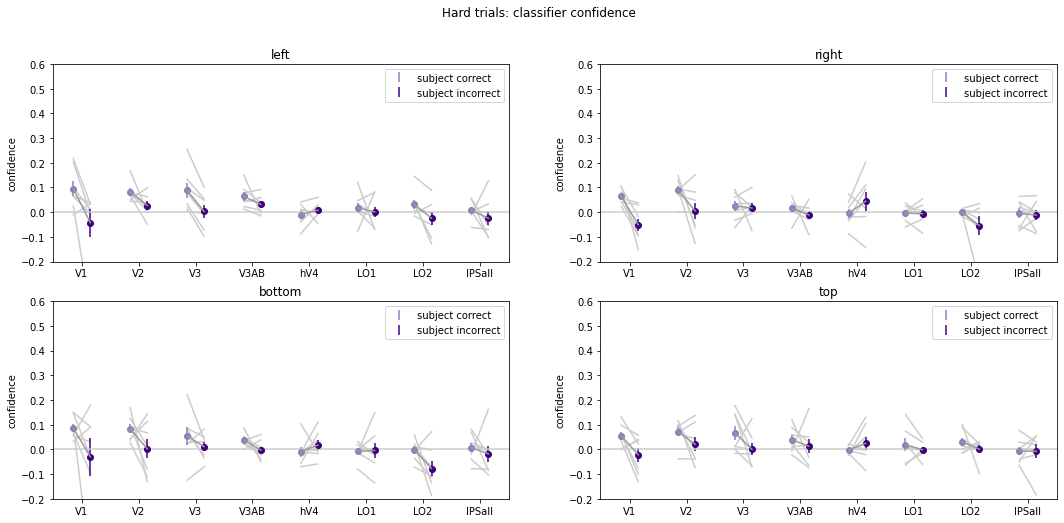

In [12]:
vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)


colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,8))

for sdi, side_name in enumerate(['left','right','bottom','top']):
    
    plt.subplot(2,2,sdi+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    for ci in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        plt.plot(x_ticks, meanvals[:,sdi,ci], 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, meanvals[:,sdi,ci], \
                         semvals[:,sdi,ci], \
                         xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,sdi,:],'-',color=[0.6, 0.6, 0.6])
        
        plt.plot(ri+x_jitter, vals[:,ri,sdi,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
        # if non_overlapping[ri]:
        #     yval = np.max(cihigh[ri,ti,:])+0.02
        #     plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.60])
    # plt.ylim([-0.05, 0.20])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['subject correct','subject incorrect'])
    
    plt.title(side_name)
    
plt.suptitle('Hard trials: classifier confidence')


In [13]:
for sdi, side_name in enumerate(['left','right','bottom','top']):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,sdi,:]

    anova_result = stats_utils.rmanova_2way(vals, ['roi','correctness'], do_shuffle=False)
    
    print('\n%s'%side_name)
    print(anova_result)


left
                   F Value  Num DF  Den DF    Pr > F
roi               1.528581     7.0    42.0  0.184149
correctness      22.784418     1.0     6.0  0.003084
roi:correctness   1.820920     7.0    42.0  0.108430

right
                  F Value  Num DF  Den DF    Pr > F
roi              1.741525     7.0    42.0  0.125414
correctness      2.891783     1.0     6.0  0.139938
roi:correctness  3.230330     7.0    42.0  0.007847

bottom
                  F Value  Num DF  Den DF    Pr > F
roi              1.390263     7.0    42.0  0.234786
correctness      3.208085     1.0     6.0  0.123463
roi:correctness  1.246912     7.0    42.0  0.299714

top
                  F Value  Num DF  Den DF    Pr > F
roi              0.909122     7.0    42.0  0.508816
correctness      3.491640     1.0     6.0  0.110895
roi:correctness  1.284659     7.0    42.0  0.281298


In [14]:
for sdi, side_name in enumerate(['left','right','bottom','top']):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,sdi,:]

    tstats_correctness = np.zeros((n_rois,),dtype=float)
    pvals_correctness = np.zeros((n_rois,),dtype=float)
    pvals_nonpar_correctness = np.zeros((n_rois,),dtype=float)
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 3535445
    for rr in range(n_rois):

        c1_values = vals[:,rr,0]
        c2_values = vals[:,rr,1]

        stats = scipy.stats.ttest_rel(c1_values, c2_values)

        tstats_correctness[rr] = stats.statistic
        pvals_correctness[rr] = stats.pvalue

        p, d = stats_utils.paired_ttest_nonpar(c1_values, c2_values, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals_nonpar_correctness[rr] = p

        subj_diffs = c1_values - c2_values
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    p_values = pvals_nonpar_correctness
  
    corr_df = pd.DataFrame({'t-stat for correct > incorrect': tstats_correctness, \
                            'pvalue': p_values, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    corr_df = corr_df.round(3)
    
    print('\n%s only'%side_name)
    print(corr_df)


left only
        t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                               2.342   0.045             6
V2                               2.003   0.083             6
V3                               4.806   0.018             7
V3AB                             1.430   0.172             5
hV4                             -0.854   0.463             4
LO1                              0.437   0.627             4
LO2                              2.054   0.092             6
IPSall                           0.826   0.502             5

right only
        t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                               3.588   0.018             7
V2                               1.876   0.162             5
V3                               0.277   0.828             5
V3AB                             0.873   0.453             6
hV4                             -1.514   0.164             5
LO1                              0.166   0.927             4
L

0
1
2
3
4
5
6


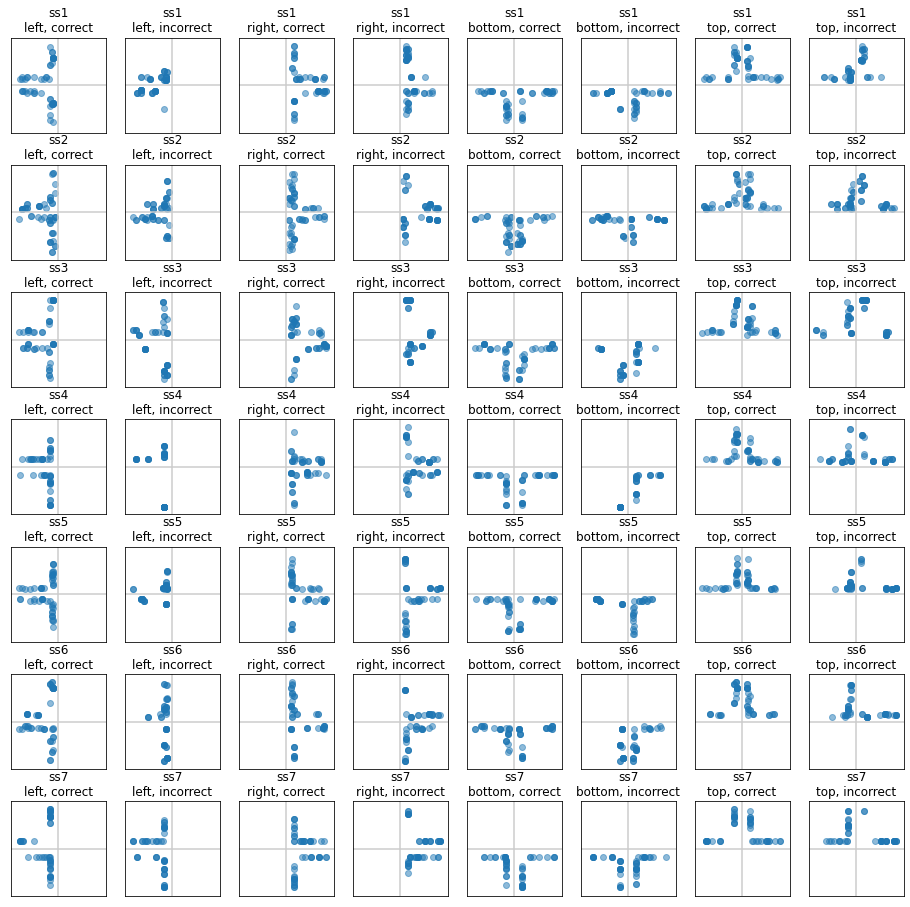

In [18]:
n_coord_bins = 12;
coord_bin_edges = np.linspace(-0.701, 0.701, n_coord_bins+1)
bin_centers = coord_bin_edges[0:-1]+(coord_bin_edges[1]-coord_bin_edges[0])/2
bin_dist = bin_centers.round(2)

n_boot_samp =50;

ti = 2; tt =3;

n_sides = 4
sides = ['left','right','bottom','top']

plt.figure(figsize=(16,16))
pi=0;

for si, ss in enumerate(subjects):

    print(si)
    
    for sdi in range(n_sides):
            
       
        l = lab[ss][lab[ss]['task']==tt]

        pt_labs = np.array([l['ptx'], l['pty']]).T

        if sides[sdi]=='left':
            side_inds = pt_labs[:,0]<2.5
        elif sides[sdi]=='right':
            side_inds = pt_labs[:,0]>2.5
        elif sides[sdi]=='bottom':
            side_inds = pt_labs[:,1]<2.5
        elif sides[sdi]=='top':
            side_inds = pt_labs[:,1]>2.5

            
        is_main_grid = l['is_main_grid']==1

        ii = ti; # focusing on the task-relevant axis here

        # is it a hard trial?
        is_hard = ~is_main_grid


        categ_actual = np.array(l['categ_task%d'%(ii+1)])

        coord_actual = np.array(l['dist_from_bound%d'%(ii+1)])
        coord_actual[categ_actual==1] = (-1)*coord_actual[categ_actual==1]

        # coord_actual = pt_labs[:,ii].round(2)

        # make rough bins that help equate stimulus distributions
        # across tasks when bootstrapping
        coord_binned = np.zeros(coord_actual.shape, dtype=int)-1
        for cb in np.arange(n_coord_bins):
            binds = (coord_actual>=coord_bin_edges[cb]) & (coord_actual<=coord_bin_edges[cb+1])
            coord_binned[binds] = cb
        assert(np.all(coord_binned[is_hard]>-1))


        # was the subject correct or incorrect?
        correct = np.array(l['subject_correct'])

        inds1 = np.where(is_hard & correct & side_inds)[0]
        inds2 = np.where(is_hard & ~correct & side_inds)[0]

        # print(len(inds1), len(inds2))

        # now figure out which bins we can use and still have everything balanced in both correct/incorrect
        un1, counts1 = np.unique(coord_binned[inds1], return_counts=True)
        un2, counts2 = np.unique(coord_binned[inds2], return_counts=True)

        # print(un1, counts1)
        # print(un2, counts2)

        # print(bin_dist[un1], bin_dist[un2])

        bins_balance = []
        for uu in np.union1d(un1, un2):
            d = bin_dist[uu]
            in1 = (d in bin_dist[un1]) and (-d in bin_dist[un1])
            in2 = (d in bin_dist[un2]) and (-d in bin_dist[un2])
            if in1 and in2:
                bins_balance += [uu]

        # print(bin_dist[bins_balance])

        # checking that the bins we are using represent each category equally
        assert(np.mean(bin_dist[bins_balance]<0)==0.5)

        n_samp_eachbin = int(np.ceil(n_boot_samp/len(bins_balance)))

        # loop over correct/incorrect trials
        for ci, [inds,name] in enumerate(zip([inds1, inds2], \
                                            ['correct','incorrect'])):

            nt = len(inds)


            # make a resampling order that represents each bin equally
            inds_resamp = []
            for bn in bins_balance:
                inds_bin = inds[coord_binned[inds]==bn]
                assert(len(inds_bin)>0)
                # if bi==0:
                #     print(len(inds_bin), n_samp_eachbin)
                inds_resamp.append(np.random.choice(inds_bin, n_samp_eachbin, replace=True))    
            inds_resamp = np.concatenate(inds_resamp, axis=0)
            # print(len(inds_resamp))

            # check that the set we created has half each category
            assert(np.mean(categ_actual[inds_resamp]==1)==0.5)

            # double check resample order
            assert(np.all(np.isin(coord_binned[inds_resamp], bins_balance)))
            counts = np.array([np.sum(coord_binned[inds_resamp]==bn) for bn in bins_balance])
            assert(np.all(counts==n_samp_eachbin))


            pi+=1
            plt.subplot(n_subjects, 8, pi)
            plt.plot(pt_labs[inds_resamp,0], \
                    pt_labs[inds_resamp,1],'o',alpha=0.5)

            plt.axis('square')
            plt.xticks([]); plt.yticks([])
            plt.title('ss%d\n%s, %s'%(ss,sides[sdi],name))
            # plt.xlim([2.5-0.8, 2.5+0.8])
            # plt.ylim([2.5-0.8, 2.5+0.8])
            plt.xlim([-0.5,5.5])
            plt.ylim([-0.5, 5.5])
            plt.axhline(2.5, color=[0.8, 0.8, 0.8])
            plt.axvline(2.5, color=[0.8, 0.8, 0.8])
    #                